This file performs a number of analyses on the models' ability to generate the data, measured via the sum of squared errors. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from textwrap import wrap

import statsmodels.api as sm
from statsmodels.formula.api import ols 

In [2]:
label_fontsize = 20
tick_fontsize = 16
wrapsize = 25

In [3]:
folder = os.path.join(os.getcwd(),'prediction_errors')

In [4]:
n_subjects = 100

edge_types = ['bin', 'con']
geometries = ['euc', 'hyp']
## Pretty plot variable names
nicelabels = {'bin':'Binary', 'con':'Continuous','euc':'Euclidean', 'hyp':'Hyperbolic'}
tasks = ['REST1', 'REST2','EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
subjects = np.arange(1,n_subjects+1)

In [5]:
edge_type = []
geometry = []
pred_errors = []
task = []
subject = []
for i, et in enumerate(edge_types):
    for j, geo in enumerate(geometries):
        ## Load prediction errors 
        filename = os.path.join(folder, f"{et}_{geo}_avg_prediction_errors.pkl")
        with open(filename, 'rb') as f:
            prediction_errors = pickle.load(f)
            
        n_subjects, n_tasks, n_obs = prediction_errors.shape
        T = n_subjects*n_tasks*n_obs
        
        pred_errors = pred_errors + list(prediction_errors.flatten())
        ## Save the correaponding subject, task, edge type and geometry 
        subject = subject + list(np.repeat(subjects, n_tasks*n_obs))
        task = task + list(np.tile(np.repeat(tasks, n_obs),n_subjects))
        edge_type = edge_type + [nicelabels[et]]*T
        geometry = geometry + [nicelabels[geo]]*T

In [6]:
## Create the dataframe
df = pd.DataFrame({'edge_type':edge_type, 'geometry':geometry, 'subject':subject, 'task':task, 'sse':pred_errors})
print(f"Min = {np.min(df['sse'])}, Max = {np.max(df['sse'])}")
df.tail()

Min = 2642.351, Max = 8359.391


,edge_type,geometry,subject,task,sse
7195,Continuous,Hyperbolic,100,RELATIONAL,4018.838112
7196,Continuous,Hyperbolic,100,SOCIAL,4569.939318
7197,Continuous,Hyperbolic,100,SOCIAL,4569.939318
7198,Continuous,Hyperbolic,100,WM,4081.624522
7199,Continuous,Hyperbolic,100,WM,4081.624522


In [7]:
## Plot constants
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:pink', 'tab:brown', 'tab:olive', 'tab:purple', 'tab:cyan']

In [8]:
## Calculate the means
hue = 'geometry'
avgs = []
n_hue = len(np.unique(df[hue]))
for et in edge_types:
    for p in np.unique(df[hue]):
        avgs.append(np.mean(df['sse'][(df['edge_type']==nicelabels[et]) & (df[hue]==p)]))
        
true_mean = np.mean(avgs)

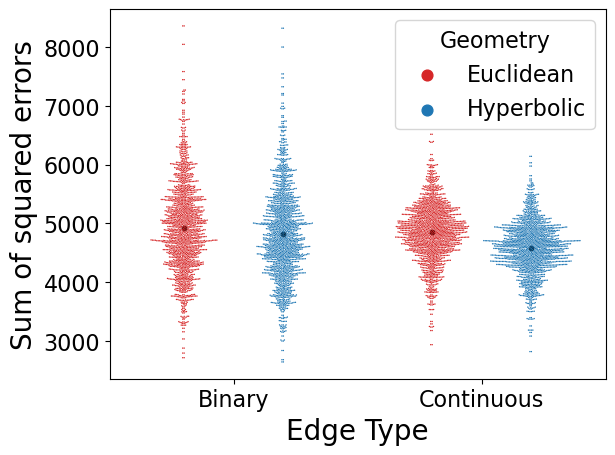

In [12]:
sns.swarmplot(y='sse', 
              x='edge_type', 
              hue=hue,
              data=df,
              s=1,
              palette=colors,
              dodge=True
             )

## Add means to the distributions
xoff = 1/(n_hue+2)
x_mids = [xmid + 1/(n_hue+2)*i-n_hue//2*xoff for xmid in range(len(edge_types)) for i in np.arange(n_hue)]
plt.scatter([-0.2, 0.2, 0.8, 1.2], avgs, s=10, color='k')
plt.xlabel('Edge Type', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.ylabel('Sum of squared errors', fontsize=label_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.legend(fontsize=tick_fontsize).set_title(title='Geometry', prop={'size':tick_fontsize}) 
savename = os.path.join(folder, f'sse.png')
plt.savefig(savename, bbox_inches='tight')
plt.show()

In [43]:
## Perform an analysis of variance
model = ols('sse ~ C(edge_type) + C(geometry) + C(edge_type):C(geometry)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(edge_type),4.518503e+07,1.0,109.844593,1.617062e-25
C(geometry),6.595102e+07,1.0,160.326633,2.340027e-36
C(edge_type):C(geometry),1.192732e+07,1.0,28.995249,7.484898e-08
Residual,2.960104e+09,7196.0,NaN,NaN


## Unused analysis on the effect size.
This was not used, because these effect size measures are made for e.g. psychology experiments, and not necessarily applicable to computational data.

In [266]:
from scipy.stats import norm

def ssmd(d1, d2, MLE = False):
    n = ((len(d1)-1)/len(d1), (len(d2)-1)/len(d2)) if MLE else (1,1)
    return (np.mean(d1) - np.mean(d2))/np.sqrt(n[0]*np.std(d1)**2 + n[1]*np.std(d2)**2)

def smd(d1, d2, left=True):
    sigma = np.std(d1) if left else np.std(d2)
    return (np.mean(d1)-np.mean(d2))/sigma

SSMD:
	Edge type: 0.17249636724026943 
	Geometry: 0.2091138716142821
SMD:
	Edge type(L): 0.20341567327913404 
	Edge type(R): 0.3253057120847524 
	Geometry(L): 0.29494259245251814 
	Geometry(R): 0.29644432085104483


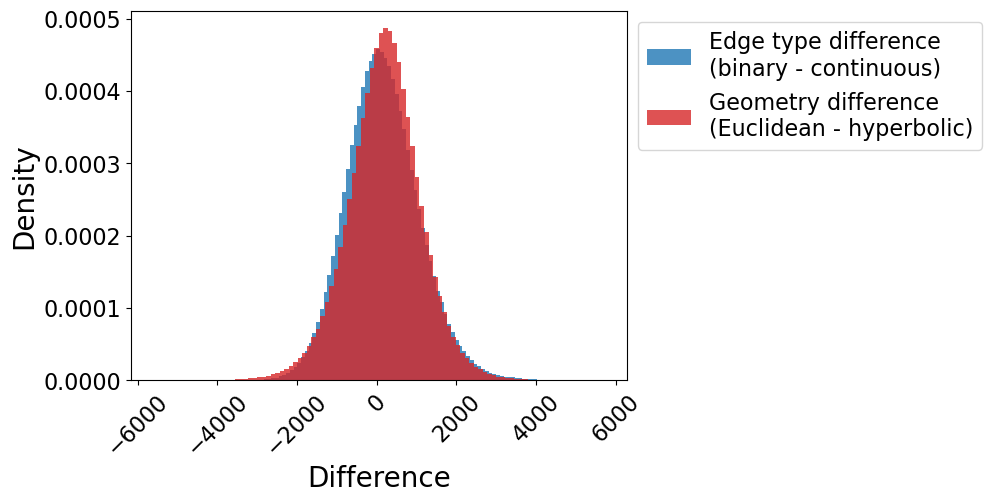

In [268]:
bin_sse = np.array(df['sse'][df['edge_type']=='Binary'])
con_sse = np.array(df['sse'][df['edge_type']=='Continuous'])
euc_sse = np.array(df['sse'][df['geometry']=='Euclidean'])
hyp_sse = np.array(df['sse'][df['geometry']=='Hyperbolic'])

n_bins = 100
n_elems = len(bin_sse) 
lw = 2
x_off = 0.05
n_points = 1000

et_diff = np.zeros(n_elems**2)
geo_diff = np.zeros(n_elems**2)

dod = np.zeros(n_elems**4)

for i in range(n_elems):
    beg = i*n_elems
    end = (i+1)*n_elems
    
    et_diff[beg:end] = bin_sse - np.roll(con_sse, i)
    geo_diff[beg:end] = euc_sse - np.roll(hyp_sse, i)

for i in range(n_elems**2):
    beg = i*n_elems**2
    end = (i+1)*n_elems**2
    dod
    
ssmd_et = ssmd(bin_sse, con_sse, True)
ssmd_geo = ssmd(euc_sse, hyp_sse, True)

smd_et = smd(bin_sse, con_sse)
smd_et_r = smd(bin_sse, con_sse, False)
smd_geo = smd(euc_sse, hyp_sse)
smd_geo_r = smd(euc_sse, hyp_sse, False)

print('SSMD:\n\tEdge type:',ssmd_et,'\n\tGeometry:',ssmd_geo)
print('SMD:\n\tEdge type(L):',smd_et,'\n\tEdge type(R):',smd_et_r,'\n\tGeometry(L):',smd_geo,'\n\tGeometry(R):',smd_geo_r)

plt.figure()
plt.hist(et_diff, n_bins, density=True, color='tab:blue', alpha=0.8)
plt.hist(geo_diff, n_bins, density=True, color='tab:red', alpha=0.8)
_labels = ['Edge type difference (binary - continuous)','Geometry difference (Euclidean - hyperbolic)']
labels = [ '\n'.join(wrap(l, wrapsize)) for l in _labels]
plt.xlabel('Difference', fontsize=label_fontsize)
plt.ylabel('Density', fontsize=label_fontsize)
plt.legend(labels, fontsize=tick_fontsize, bbox_to_anchor=(1,1))#.set_title('Variable', prop={'size':label_fontsize})
plt.xticks(fontsize=tick_fontsize, rotation=45)
plt.yticks(fontsize=tick_fontsize)
savename = os.path.join(folder, f'sse_differences.png')
plt.savefig(savename, bbox_inches='tight')
plt.show()

In [263]:
df_bin = df[df['edge_type']=='Binary']
df_euc = df[df['geometry']=='Euclidean']

In [264]:
model = ols('sse ~ C(geometry)', data=df_bin).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(geometry),1.0,1.089245e+07,1.089245e+07,18.034424,0.000022
Residual,3598.0,2.173123e+09,6.039808e+05,NaN,NaN


In [265]:
model = ols('sse ~ C(edge_type)', data=df_euc).fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(edge_type),1.0,5.341175e+06,5.341175e+06,12.719028,0.000367
Residual,3598.0,1.510929e+09,4.199358e+05,NaN,NaN
